# 🧱 DCGAN - Bricks Data

In this notebook, we'll walk through the steps required to train your own DCGAN on the bricks dataset

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

## 0. Parameters <a name="parameters"></a>

In [40]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 20
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [38]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
GOOGLE_DRIVE_DIR = "/content/gdrive/My Drive/bdc_2024_summer/data/dataset/"

Mounted at /content/gdrive


In [5]:
train_data = utils.image_dataset_from_directory(
    GOOGLE_DRIVE_DIR,
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 6618 files belonging to 1 classes.


In [6]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

the original data is scaled in the range of [0,255] to denote the pixel intentity. When training GANs we rescale the data to the range[-1,1] so that we can use the tanh activation function on the final layer of the generator.

In [23]:
train_sample = sample_batch(train)

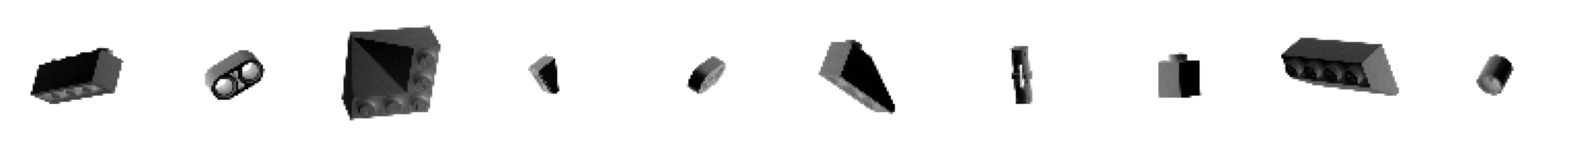

In [24]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [25]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) # <1>
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
) #<2>
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x) #<3>

discriminator = models.Model(discriminator_input, discriminator_output) #<4>
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

1. input layer of the discriminator
2. stack `Conv2D` layers on top of each other, with `BatchNormalization`, `LeakyReLu` activation and `Dropout` layers sandwiched in between
3. Faltten the last convolutional layer -- by this point, the shape of the tensor is 1 x 1 x 1 so there is no need for a final `Dense` layer
4. The Keras model that defines the discriminator -- a model that takes an input image and outputs a single number bewteen 0 and 1.

In [26]:
generator_input = layers.Input(shape=(Z_DIM,)) #<1>
x = layers.Reshape((1, 1, Z_DIM))(generator_input) #<2>
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x) #<3>
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x) #<4>
generator = models.Model(generator_input, generator_output) #<5>
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

1. Input layer of the generator a vector of length 100
2. We use a `Reshape` layer to give a 1 x 1 x100 tensor, so that we can start applying convolutional transpose operations
3. We pass this through four `Conv2DTranspose` layers, with `BatchNormalization` and `LeakyReLU` layer sandwiched in between.
4. The final `Conv2DTranspose` layer uses a tanh activation function to transform the output to range [-1,1], to match the original image domain
5. The Keras model that defines the generator -- a model that accepts a vector of length 100 and outputs a tensor of shape [64, 64, 1]

In [27]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy() #<1>
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        ) #<2>

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            ) #<3>
            real_predictions = self.discriminator(real_images, training=True) #<4>
            fake_predictions = self.discriminator(
                generated_images, training=True
            ) #<5>

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0 #<6>

            g_loss = self.loss_fn(real_labels, fake_predictions) #<7>

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        ) #<8>
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

1. The loss function for the generator and discriminator is `BinaryCrossentropy`
2. To train the network, first sample a batch of vectors from a multivariate standard normal distribution
3. Next, pass these through the generator to produce a batch of generated images
4. Now ask the discriminator to predict the realness of the batch of real images
5. and the batch of generated images
6. The discriminator loss is the average binary crossentropy across both the real and fake images
7. The generator loss is the binary crossentropy between the discriminator predictions for the generated images and a label of 1
8. Update the weights of the discriminator and generator seperately

In [28]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [29]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [30]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [42]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
        )

Epoch 1/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0441 - d_real_acc: 0.8994 - d_fake_acc: 0.9152 - d_acc: 0.9073 - g_loss: 4.9603 - g_acc: 0.0848

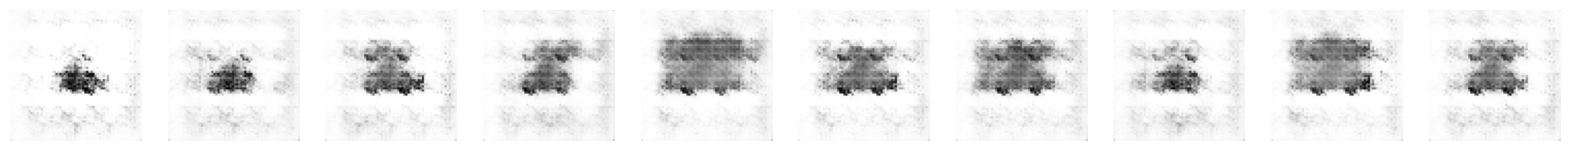

52/52 [==============================] - 160s 3s/step - d_loss: 0.0441 - d_real_acc: 0.8994 - d_fake_acc: 0.9152 - d_acc: 0.9073 - g_loss: 4.9603 - g_acc: 0.0848
Epoch 2/20
52/52 [==============================] - ETA: 0s - d_loss: -0.0317 - d_real_acc: 0.9198 - d_fake_acc: 0.9325 - d_acc: 0.9261 - g_loss: 5.0524 - g_acc: 0.0675

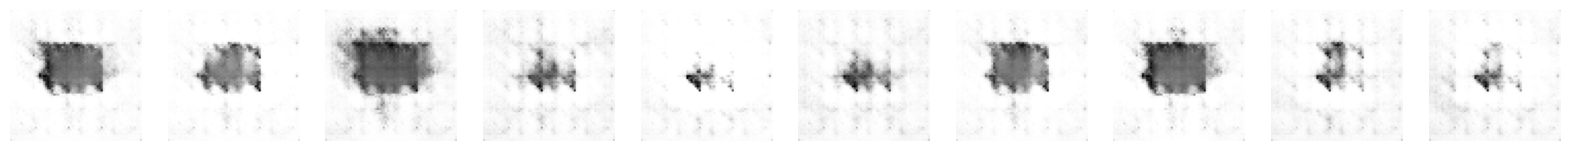

52/52 [==============================] - 31s 531ms/step - d_loss: -0.0317 - d_real_acc: 0.9198 - d_fake_acc: 0.9325 - d_acc: 0.9261 - g_loss: 5.0524 - g_acc: 0.0675
Epoch 3/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0432 - d_real_acc: 0.9021 - d_fake_acc: 0.9214 - d_acc: 0.9118 - g_loss: 5.2118 - g_acc: 0.0786

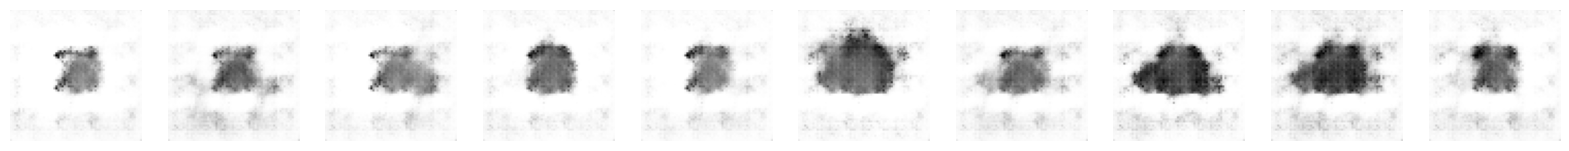

52/52 [==============================] - 27s 449ms/step - d_loss: 0.0432 - d_real_acc: 0.9021 - d_fake_acc: 0.9214 - d_acc: 0.9118 - g_loss: 5.2118 - g_acc: 0.0786
Epoch 4/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0539 - d_real_acc: 0.9095 - d_fake_acc: 0.9146 - d_acc: 0.9121 - g_loss: 6.3748 - g_acc: 0.0854

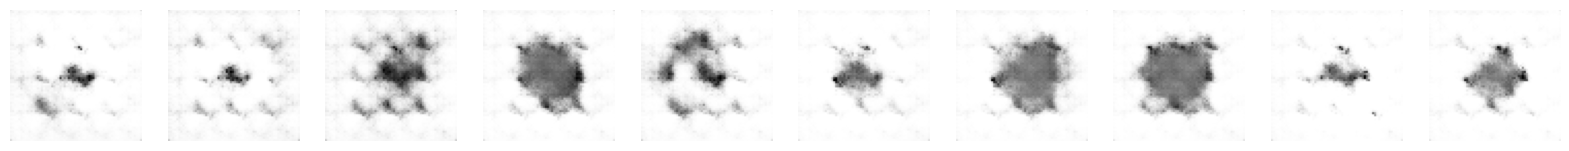

52/52 [==============================] - 27s 440ms/step - d_loss: 0.0539 - d_real_acc: 0.9095 - d_fake_acc: 0.9146 - d_acc: 0.9121 - g_loss: 6.3748 - g_acc: 0.0854
Epoch 5/20
52/52 [==============================] - ETA: 0s - d_loss: -0.0719 - d_real_acc: 0.9367 - d_fake_acc: 0.9453 - d_acc: 0.9410 - g_loss: 4.7614 - g_acc: 0.0547

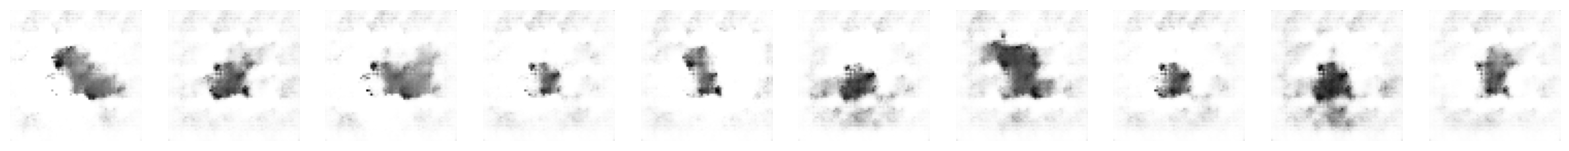

52/52 [==============================] - 26s 437ms/step - d_loss: -0.0719 - d_real_acc: 0.9367 - d_fake_acc: 0.9453 - d_acc: 0.9410 - g_loss: 4.7614 - g_acc: 0.0547
Epoch 6/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0363 - d_real_acc: 0.8927 - d_fake_acc: 0.9027 - d_acc: 0.8977 - g_loss: 5.4913 - g_acc: 0.0973

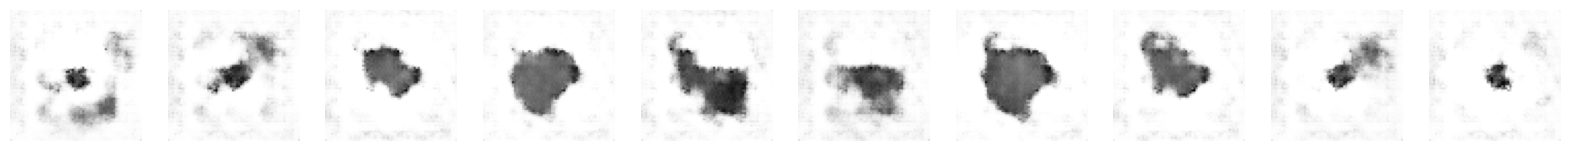

52/52 [==============================] - 27s 430ms/step - d_loss: 0.0363 - d_real_acc: 0.8927 - d_fake_acc: 0.9027 - d_acc: 0.8977 - g_loss: 5.4913 - g_acc: 0.0973
Epoch 7/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0603 - d_real_acc: 0.8929 - d_fake_acc: 0.8995 - d_acc: 0.8962 - g_loss: 5.6340 - g_acc: 0.1005

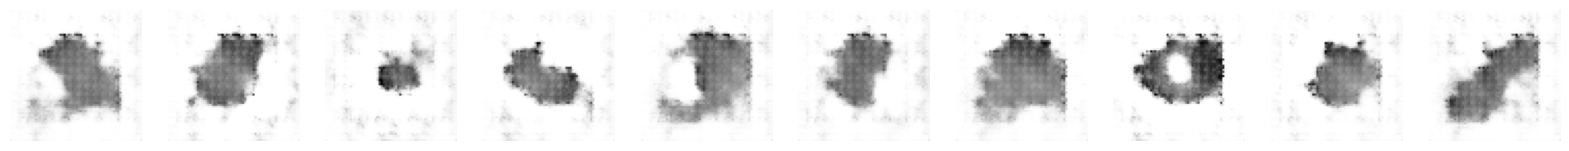

52/52 [==============================] - 28s 439ms/step - d_loss: 0.0603 - d_real_acc: 0.8929 - d_fake_acc: 0.8995 - d_acc: 0.8962 - g_loss: 5.6340 - g_acc: 0.1005
Epoch 8/20
52/52 [==============================] - ETA: 0s - d_loss: 0.1703 - d_real_acc: 0.8720 - d_fake_acc: 0.8803 - d_acc: 0.8762 - g_loss: 6.1874 - g_acc: 0.1197

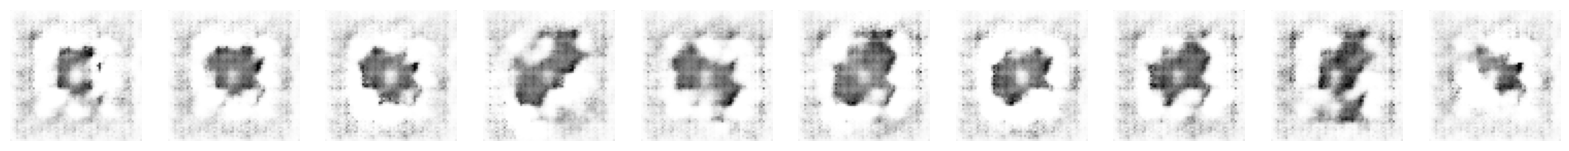

52/52 [==============================] - 28s 441ms/step - d_loss: 0.1703 - d_real_acc: 0.8720 - d_fake_acc: 0.8803 - d_acc: 0.8762 - g_loss: 6.1874 - g_acc: 0.1197
Epoch 9/20
52/52 [==============================] - ETA: 0s - d_loss: -0.2643 - d_real_acc: 0.9562 - d_fake_acc: 0.9578 - d_acc: 0.9570 - g_loss: 8.2442 - g_acc: 0.0422

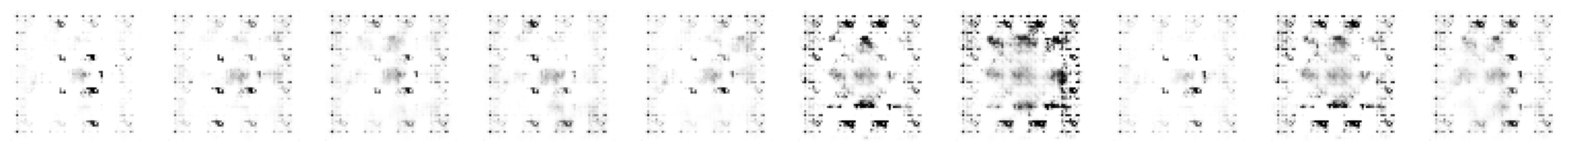

52/52 [==============================] - 30s 475ms/step - d_loss: -0.2643 - d_real_acc: 0.9562 - d_fake_acc: 0.9578 - d_acc: 0.9570 - g_loss: 8.2442 - g_acc: 0.0422
Epoch 10/20
52/52 [==============================] - ETA: 0s - d_loss: -0.1141 - d_real_acc: 0.9379 - d_fake_acc: 0.9338 - d_acc: 0.9359 - g_loss: 8.9109 - g_acc: 0.0662

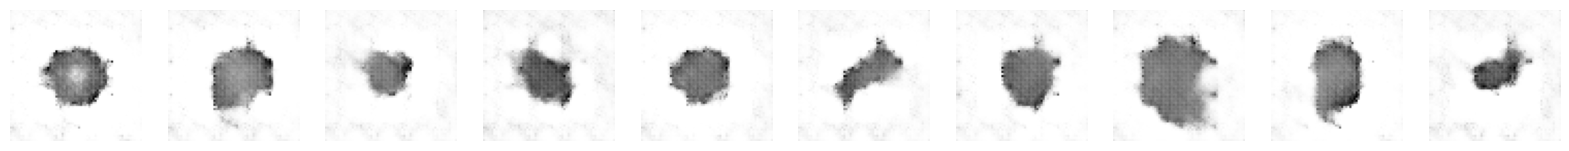

52/52 [==============================] - 27s 440ms/step - d_loss: -0.1141 - d_real_acc: 0.9379 - d_fake_acc: 0.9338 - d_acc: 0.9359 - g_loss: 8.9109 - g_acc: 0.0662
Epoch 11/20
52/52 [==============================] - ETA: 0s - d_loss: 0.3638 - d_real_acc: 0.8172 - d_fake_acc: 0.8137 - d_acc: 0.8154 - g_loss: 3.6575 - g_acc: 0.1863

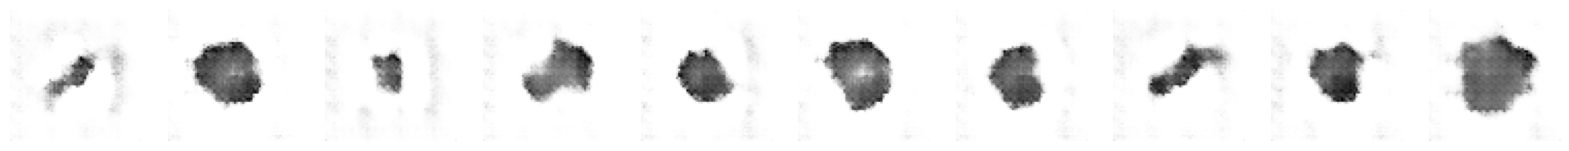

52/52 [==============================] - 29s 482ms/step - d_loss: 0.3638 - d_real_acc: 0.8172 - d_fake_acc: 0.8137 - d_acc: 0.8154 - g_loss: 3.6575 - g_acc: 0.1863
Epoch 12/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0500 - d_real_acc: 0.8980 - d_fake_acc: 0.8950 - d_acc: 0.8965 - g_loss: 4.6455 - g_acc: 0.1050

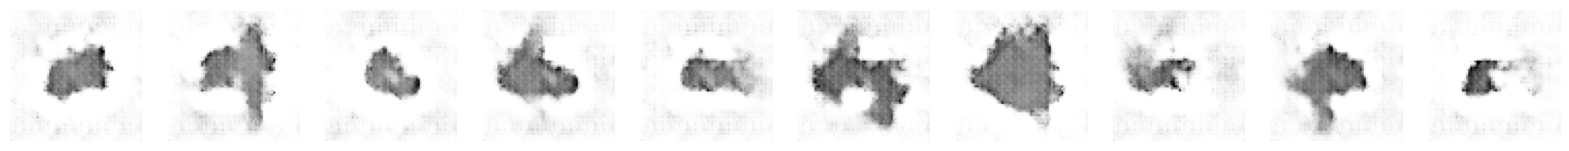

52/52 [==============================] - 28s 442ms/step - d_loss: 0.0500 - d_real_acc: 0.8980 - d_fake_acc: 0.8950 - d_acc: 0.8965 - g_loss: 4.6455 - g_acc: 0.1050
Epoch 13/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0322 - d_real_acc: 0.9047 - d_fake_acc: 0.8995 - d_acc: 0.9021 - g_loss: 5.1283 - g_acc: 0.1005

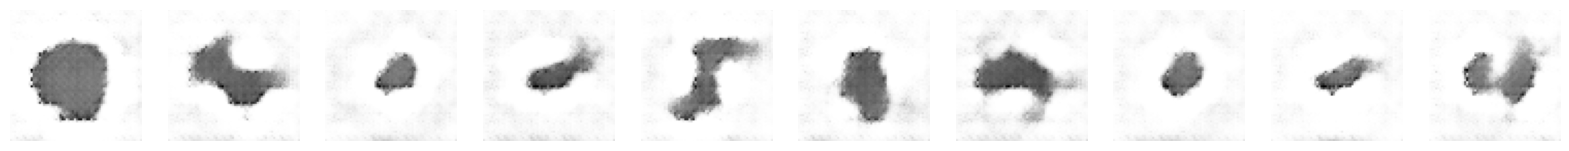

52/52 [==============================] - 27s 448ms/step - d_loss: 0.0322 - d_real_acc: 0.9047 - d_fake_acc: 0.8995 - d_acc: 0.9021 - g_loss: 5.1283 - g_acc: 0.1005
Epoch 14/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0431 - d_real_acc: 0.8865 - d_fake_acc: 0.8963 - d_acc: 0.8914 - g_loss: 4.7362 - g_acc: 0.1037

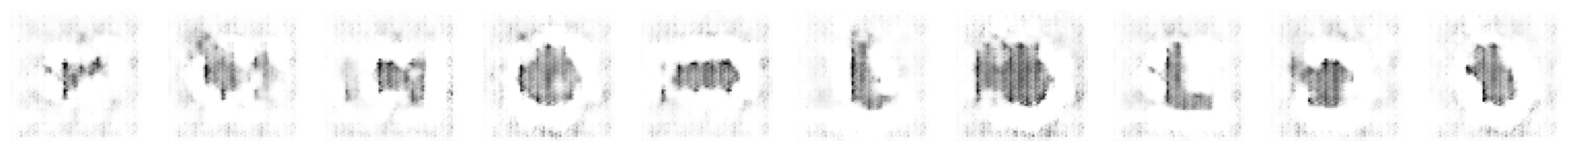

52/52 [==============================] - 29s 480ms/step - d_loss: 0.0431 - d_real_acc: 0.8865 - d_fake_acc: 0.8963 - d_acc: 0.8914 - g_loss: 4.7362 - g_acc: 0.1037
Epoch 15/20
52/52 [==============================] - ETA: 0s - d_loss: -0.0343 - d_real_acc: 0.9108 - d_fake_acc: 0.9077 - d_acc: 0.9093 - g_loss: 6.9105 - g_acc: 0.0923

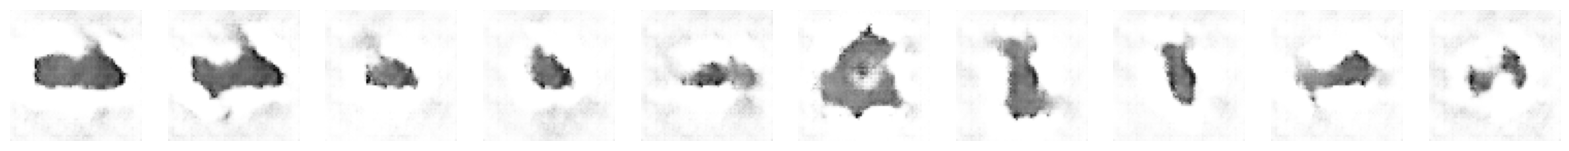

52/52 [==============================] - 28s 479ms/step - d_loss: -0.0343 - d_real_acc: 0.9108 - d_fake_acc: 0.9077 - d_acc: 0.9093 - g_loss: 6.9105 - g_acc: 0.0923
Epoch 16/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0647 - d_real_acc: 0.8926 - d_fake_acc: 0.8914 - d_acc: 0.8920 - g_loss: 4.5090 - g_acc: 0.1086

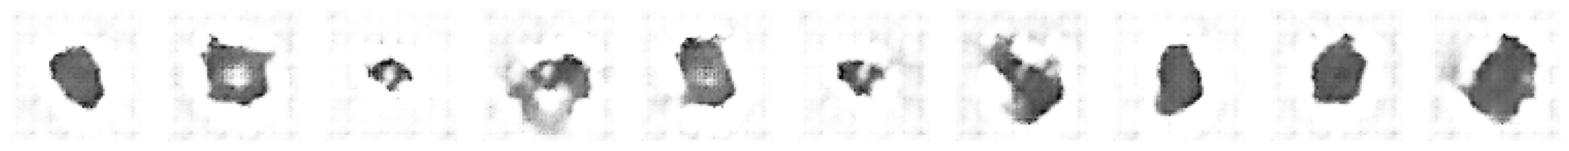

52/52 [==============================] - 29s 504ms/step - d_loss: 0.0647 - d_real_acc: 0.8926 - d_fake_acc: 0.8914 - d_acc: 0.8920 - g_loss: 4.5090 - g_acc: 0.1086
Epoch 17/20
52/52 [==============================] - ETA: 0s - d_loss: 0.1460 - d_real_acc: 0.8601 - d_fake_acc: 0.8702 - d_acc: 0.8651 - g_loss: 4.4799 - g_acc: 0.1298

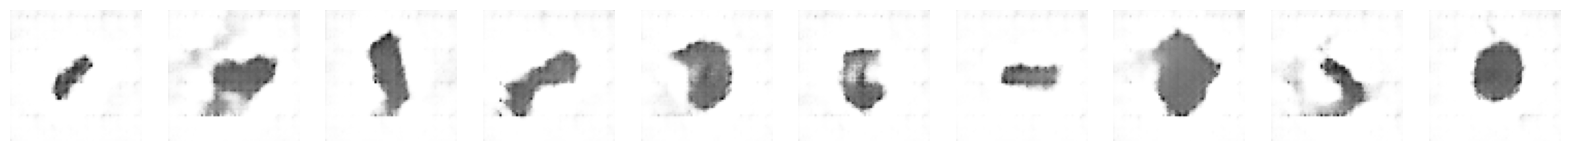

52/52 [==============================] - 28s 459ms/step - d_loss: 0.1460 - d_real_acc: 0.8601 - d_fake_acc: 0.8702 - d_acc: 0.8651 - g_loss: 4.4799 - g_acc: 0.1298
Epoch 18/20
52/52 [==============================] - ETA: 0s - d_loss: 0.0670 - d_real_acc: 0.8856 - d_fake_acc: 0.8861 - d_acc: 0.8858 - g_loss: 5.0993 - g_acc: 0.1139

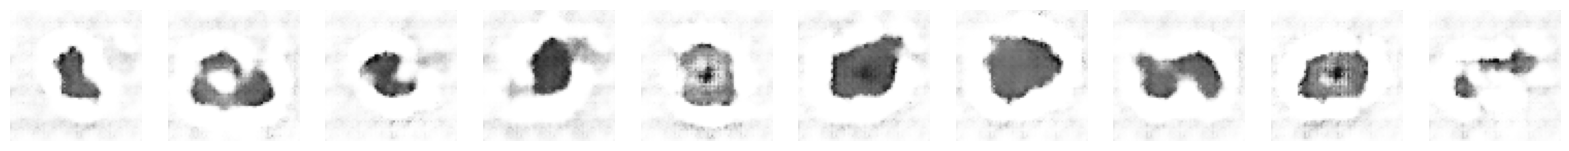

52/52 [==============================] - 28s 464ms/step - d_loss: 0.0670 - d_real_acc: 0.8856 - d_fake_acc: 0.8861 - d_acc: 0.8858 - g_loss: 5.0993 - g_acc: 0.1139
Epoch 19/20
52/52 [==============================] - ETA: 0s - d_loss: 0.1089 - d_real_acc: 0.8846 - d_fake_acc: 0.8749 - d_acc: 0.8797 - g_loss: 4.2888 - g_acc: 0.1251

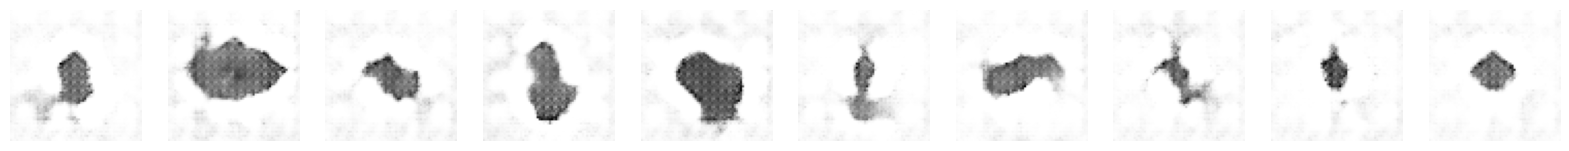

52/52 [==============================] - 30s 492ms/step - d_loss: 0.1089 - d_real_acc: 0.8846 - d_fake_acc: 0.8749 - d_acc: 0.8797 - g_loss: 4.2888 - g_acc: 0.1251
Epoch 20/20
52/52 [==============================] - ETA: 0s - d_loss: 0.1391 - d_real_acc: 0.8909 - d_fake_acc: 0.8926 - d_acc: 0.8917 - g_loss: 5.4312 - g_acc: 0.1074

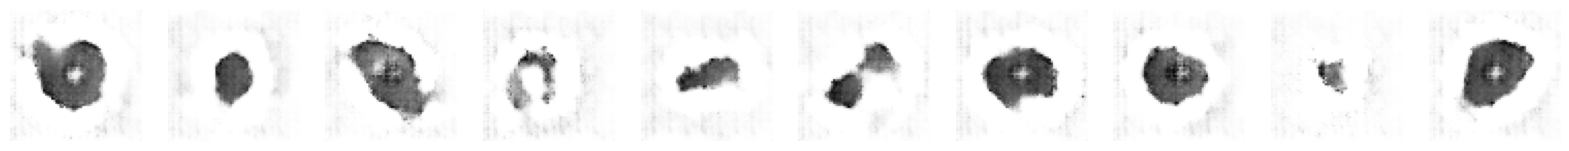

52/52 [==============================] - 29s 459ms/step - d_loss: 0.1391 - d_real_acc: 0.8909 - d_fake_acc: 0.8926 - d_acc: 0.8917 - g_loss: 5.4312 - g_acc: 0.1074


In [43]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [44]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

## 3. Generate new images <a name="decode"></a>

In [45]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [46]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 1s 717ms/step


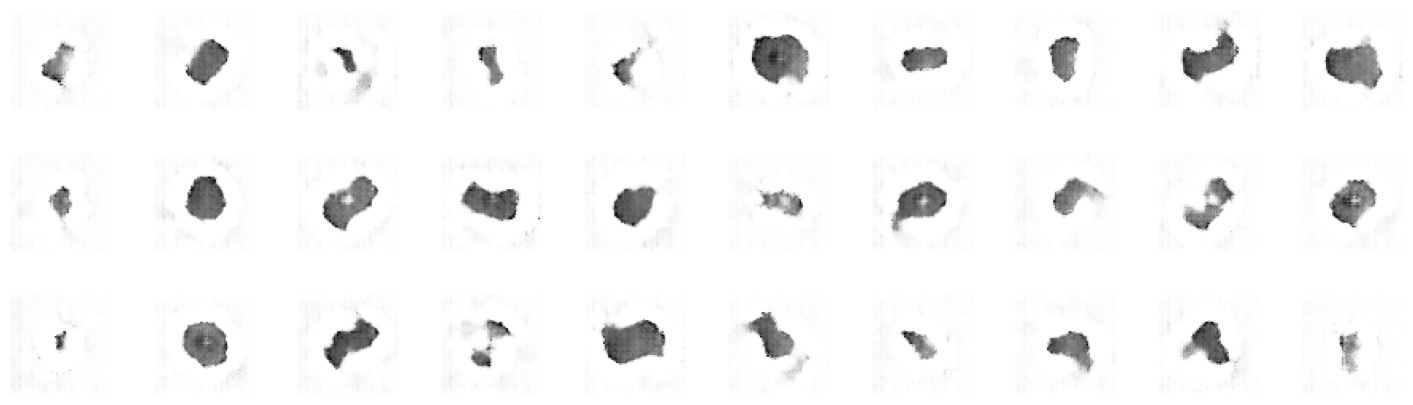

In [47]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [48]:
# L1 distance
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [49]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 486ms/step


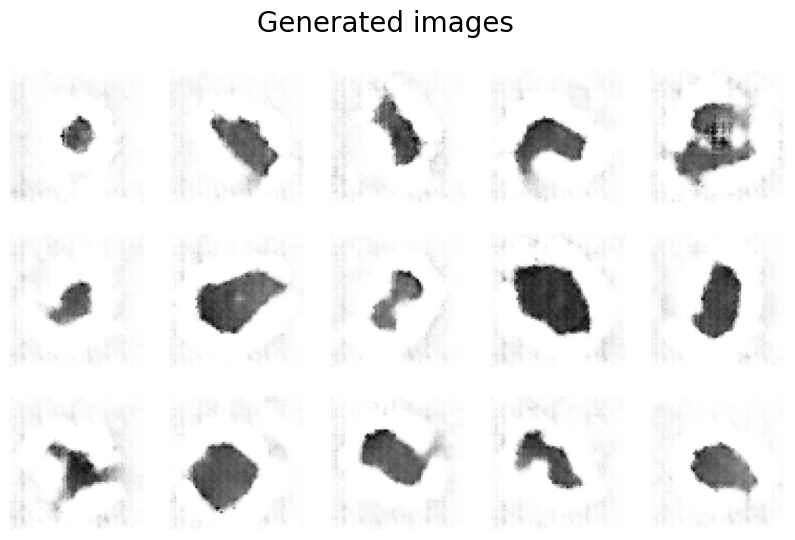

In [50]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

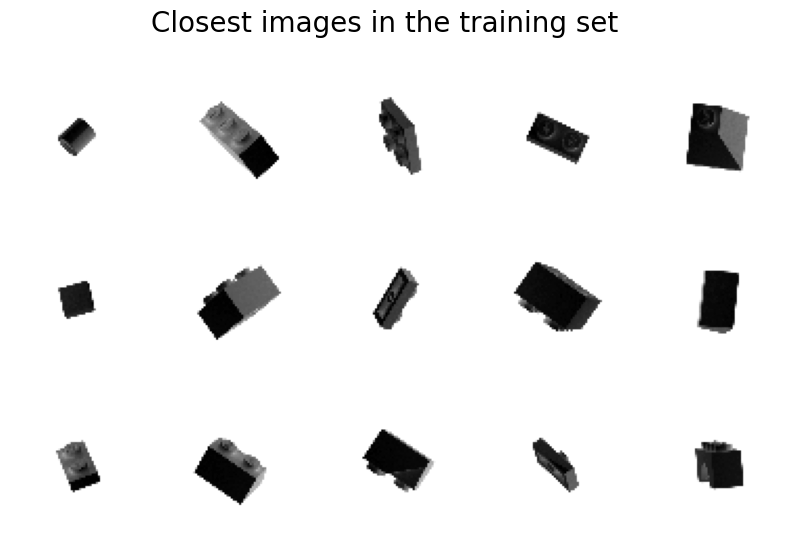

In [51]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()